# Nhận dạng văn bản viết tay

...

### Nhận dạng văn bản viết tay là gì?

Nhận dạng văn bản viết tay là quá trình nhận dạng và chuyển đổi chữ viết tay thành văn bản có thể sử dụng và xử lý được. Nó có ứng dụng rộng rãi trong nhiều lĩnh vực, bao gồm: chuyển đổi tài liệu cổ điển thành văn bản số hóa, xử lý tự động các biểu mẫu hoặc giấy tờ, nhận dạng chữ viết tay trong bức ảnh hoặc video, và hỗ trợ các ứng dụng ghi chú hoặc giao tiếp dựa trên chữ viết tay.



### Ý nghĩa và ứng dụng :

Bài toán Nhận dạng chữ viết có nhiều ứng dụng quan trọng, bao gồm :

- Nhận dạng biển số xe: Hệ thống nhận dạng chữ viết có thể được áp dụng để tự động nhận dạng biển số xe trong các hệ thống giám sát giao thông. 
- Xử lý tự động văn bản: Các hệ thống nhận dạng chữ viết có thể giúp xử lý tự động văn bản, như nhận dạng chữ ký, nhận dạng ý kiến từ dữ liệu văn bản, và hỗ trợ tìm kiếm thông tin từ các tài liệu văn bản.
- Giao diện người-máy: Nhận dạng chữ viết cũng có thể được sử dụng trong các ứng dụng giao diện người-máy, như nhận dạng chữ viết tay trong các thiết bị di động hoặc bảng điều khiển. 

### Phương pháp xử lí:

- Bước 1 : Xây dựng classifier để phân loại chữ số (0-9) và ký tự (A-Z) bằng kiến trúc CNN
- Bước 2 : Phân đoạn ký tự trong hình ảnh chữ viết tay
- Bước 3 : Nhận diện lần lượt từng chữ cái được phân đoạn cho đến hết.

##### Thư viện

In [ ]:
import keras.models
import numpy as np
# import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
# import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras import utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense, MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Xử lí dữ liệu

##### Load dữ lệu huẩn luyện (train data)

In [2]:
dir = "input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#", "$", "&", "@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir, i)
    for j in os.listdir(sub_directory):
        # count += 1
        # if count > 400:
        #     break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        train_data.append([img, i])

##### Số lượng dữ liệu huấn luyện (train data)

In [3]:
len(train_data)

751228

##### Load dữ liệu đánh giá (Validation data)

In [4]:
val_dir = "input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        # count += 1
        # if count > 100:
        #     break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        img = cv2.resize(img, (img_size, img_size))
        val_data.append([img, i])

##### Số lượng dữ liệu đánh giá (Validation data)

In [5]:
len(val_data)

18104

##### Xáo trộn dữ liệu

In [6]:
random.shuffle(train_data)
random.shuffle(val_data)

##### Phân tách features(đặc trưng) và label (nhãn) của tập dữ liệu huấn luyện (train)

In [7]:
train_X = []
train_Y = []
for features, label in train_data:
    train_X.append(features)
    train_Y.append(label)

##### Phân tách features(đặc trưng) và label (nhãn) của tập dữ liệu đánh giá (Validation data)

In [8]:
val_X = []
val_Y = []
for features, label in val_data:
    val_X.append(features)
    val_Y.append(label)

##### Mã hóa dữ liệu đích thành dạng ma trận nhị phân

In [9]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

##### Chuyển đổi dữ liệu thành một mảng numpy

- Dữ liệu huấn luyện (Train data)

In [10]:
train_X = np.array(train_X) / 255.0
train_X = train_X.reshape(-1, 32, 32, 1)
train_Y = np.array(train_Y)

- Dữ liệu đánh giá (Validation data)

In [11]:
val_X = np.array(val_X) / 255.0
val_X = val_X.reshape(-1, 32, 32, 1)
val_Y = np.array(val_Y)

##### Kích thước của dữ liệu

In [12]:
print(train_X.shape,val_X.shape)

(751228, 32, 32, 1) (18104, 32, 32, 1)


In [13]:
print(train_Y.shape,val_Y.shape)

(751228, 35) (18104, 35)


# Định nghĩa model

In [14]:
model = Sequential()

### Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
#####  dùng hàm relu làm activation và chỉ rõ input_shape cho layer đầu tiên

In [15]:
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))

### Thêm Max pooling layer

In [16]:
model.add(MaxPooling2D(pool_size=(2,2)))

### Thêm Convolutional layer

In [17]:
model.add(Conv2D(64, (3, 3), activation='relu'))

### Thêm Max pooling layer

In [18]:
model.add(MaxPooling2D(pool_size=(2,2)))

### Thêm Convolutional layer

In [19]:
model.add(Conv2D(128, (3, 3), activation='relu'))

### Thêm Max pooling layer

In [20]:
model.add(MaxPooling2D(pool_size=(2,2)))

### Lớp Dropout tránh overfitting

In [21]:
model.add(Dropout(0.25))

### Flatten layer chuyển từ tensor sang vector

In [22]:
model.add(Flatten())

### Thêm Fully Connected layer với 128 nodes và dùng hàm relu

In [23]:
model.add(Dense(128, activation='relu'))

### Lớp Dropout tránh overfitting

In [24]:
model.add(Dropout(0.2))

### Output layer với 35 node và dùng softmax function để chuyển sang xác suất.

In [25]:
model.add(Dense(35, activation='softmax'))

# Kiến trúc của mô hình nơ-ron

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

# Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức đùng để tối ưu hàm loss function.

In [27]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

# Thực hiện train model với data

In [28]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
23476/23476 [==============================] - 1148s 49ms/step - loss: 0.3082 - accuracy: 0.9014 - val_loss: 0.2242 - val_accuracy: 0.9299
Epoch 2/50
23476/23476 [==============================] - 1128s 48ms/step - loss: 0.2161 - accuracy: 0.9287 - val_loss: 0.2093 - val_accuracy: 0.9331
Epoch 3/50
23476/23476 [==============================] - 994s 42ms/step - loss: 0.2035 - accuracy: 0.9328 - val_loss: 0.1983 - val_accuracy: 0.9368
Epoch 4/50
23476/23476 [==============================] - 975s 42ms/step - loss: 0.1973 - accuracy: 0.9344 - val_loss: 0.2042 - val_accuracy: 0.9391
Epoch 5/50
23476/23476 [==============================] - 986s 42ms/step - loss: 0.1941 - accuracy: 0.9355 - val_loss: 0.1992 - val_accuracy: 0.9345
Epoch 6/50
23476/23476 [==============================] - 984s 42ms/step - loss: 0.1920 - accuracy: 0.9360 - val_loss: 0.2229 - val_accuracy: 0.9281
Epoch 7/50
23476/23476 [==============================] - 976s 42ms/step - loss: 0.1913 - accuracy: 0.93

# Vẽ đồ thị loss, accuracy của training set và validation set

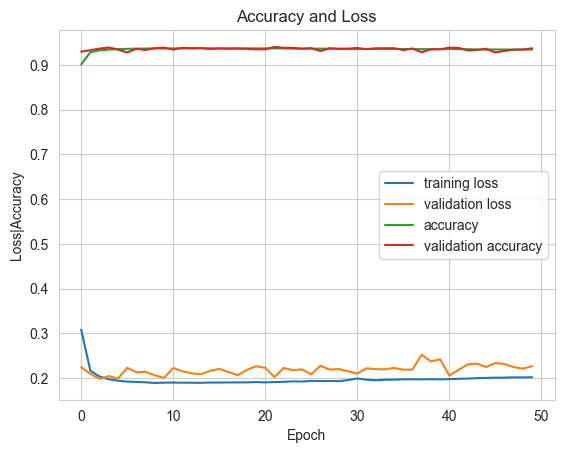

In [29]:
fig = plt.figure()
numOfEpoch = 50
plt.plot(np.arange(0, numOfEpoch), history.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), history.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), history.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()
plt.show()

# Save model, LabelBinarizer()

In [ ]:
model.save("output/char_regconition_751228_18104.keras")
model.save("output/char_regconition_751228_18104.h5")
history_df = pd.DataFrame(history.history)
history_df.to_csv('output/training_history.csv', index=False)

In [33]:
with open('output/lb.pkl', 'wb') as file:
    pickle.dump(LB, file)

# Load model, LabelBinarizer()

In [33]:
model = keras.models.load_model("output/char_regconition_14000_3500.keras")

In [34]:
LB = LabelBinarizer()
with open('output/lb.pkl', 'rb') as file:
    LB = pickle.load(file)

# Nhận diện nhiều ký tự

### Hàm xử lí

In [34]:
def get_letters(path):
    letters = []
    
    # đọc hình ảnh từ đường dẫn
    image = cv2.imread(path)
    
    # chuyển đổi sang độ xám
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Áp dụng ngưỡng để phân biệt chữ cái và nền
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
    
    # mở rộng các vùng sáng của hình ảnh
    dilated = cv2.dilate(thresh, None, iterations=1)
    
    # tìm các đường viền trong hình ảnh nhị phân
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # danh sách các đường viền
    cnts = imutils.grab_contours(cnts)
    
    # sort_contours: left to right
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][0], reverse=False))
    
    # duyệt qua từng đường viền
    for c in cnts:
        # nếu diện tích > 10 thì được coi là một ký tự
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        
        # Lấy vùng quan tâm (region of interest - ROI) 
        roi = gray[y:y + h, x:x + w]
        
        # Áp dụng ngưỡng nhị phân nghịch đảo và tự động xác định ngưỡng Otsu
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        # Điều chỉnh kích thước của ROI thành 32x32 pixel
        thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
        
        # Chuyển đổi ROI thành dạng mảng numpy và chuẩn hóa giá trị pixel trong khoảng từ 0 đến 1
        thresh = thresh.astype("float32") / 255.0
        
        # thm 1 chiều mới ở vị trí cuối
        thresh = np.expand_dims(thresh, axis=-1)
        
        # Thay đổi kích thước của mảng thành (1, 32, 32, 1) để phù hợp với kích thước đầu vào của mô hình
        thresh = thresh.reshape(1, 32, 32, 1)
        
        # Sử dụng mô hình (model) để dự đoán
        ypred = model.predict(thresh)
        
        # chuyển đổi các vector thành nhãn ký tự tương ứng
        ypred = LB.inverse_transform(ypred)
        
        # thêm kêt quả vào danh sách letters
        [x] = ypred
        letters.append(x)
        
    return letters, image

In [35]:
def get_word(letter):
    word = "".join(letter)
    return word

# Kiểm tra

1/1 [==============================] - 0s 27ms/step
BTNES


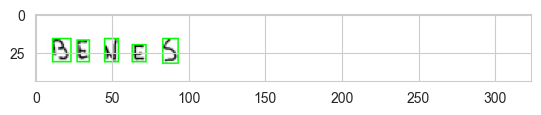

In [36]:
letter,image = get_letters("input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 38ms/step
LIL01


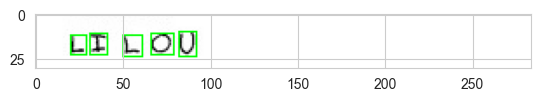

In [37]:
letter,image = get_letters("input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 30ms/step
IAFFF1X


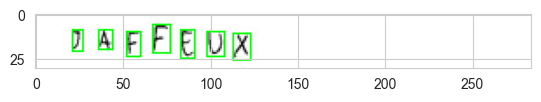

In [38]:
letter,image = get_letters("input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 31ms/step
RUFP


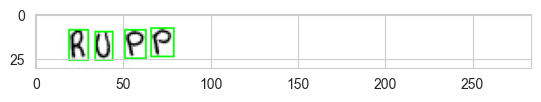

In [39]:
letter,image = get_letters("input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 26ms/step
YA1ENTJNR


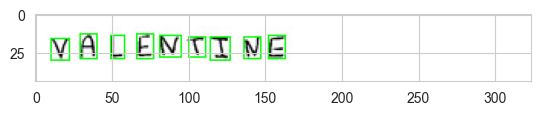

In [40]:
letter,image = get_letters("input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

# Đánh giá model

### 0. load Model và tập dữ liệu đánh giá

In [2]:
trained_model = keras.models.load_model("char_regconition.keras")
with open('label_binarizer.pkl', 'rb') as file:
    lb  = pickle.load(file)
dataset = []
dirt = "Characters_fonts_dataset\\Images\\Images"
for i in os.listdir(dirt):  
    count = 0
    sub_directory = os.path.join(dirt, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 200:
            break
        img = cv2.imread(os.path.join(sub_directory, j), 0)
        # img = cv2.resize(img, (32, 32))
        dataset.append([img, i])
random.shuffle(dataset)
x_pred = []
y_true = []
y_pred = []
for feature, label in dataset:
    x_pred.append(feature)
    y_true.append(label)
x_pred = np.array(x_pred)/255.0
x_pred = x_pred.reshape(-1, 32, 32, 1)
y_pred_lb = trained_model.predict(x_pred)
y_pred = lb.inverse_transform(y_pred_lb)

163/163 [==============================] - 3s 15ms/step


### 1. Độ chính xác (Accuracy)
Đây là tỷ lệ phần trăm các dự đoán chính xác trên tổng số mẫu kiểm tra.

In [3]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.44846153846153847


### 2. Báo cáo phân loại (Classification Report)
Cung cấp thông tin về precision, recall, F1-score cho từng lớp.

In [4]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
           A       0.50      0.54      0.52       200
           B       0.58      0.51      0.54       200
           C       0.51      0.29      0.37       200
           D       0.49      0.39      0.43       200
           E       0.57      0.34      0.43       200
           F       0.39      0.64      0.48       200
           G       0.71      0.21      0.32       200
           H       0.65    

D:\PyCharm\PythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\PyCharm\PythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\PyCharm\PythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\PyCharm\PythonProject\venv\Lib\site-packages\

### 3. ROC Curve và AUC (Area Under the Curve)
Đánh giá hiệu suất model dựa trên tỷ lệ true positive và false positive.

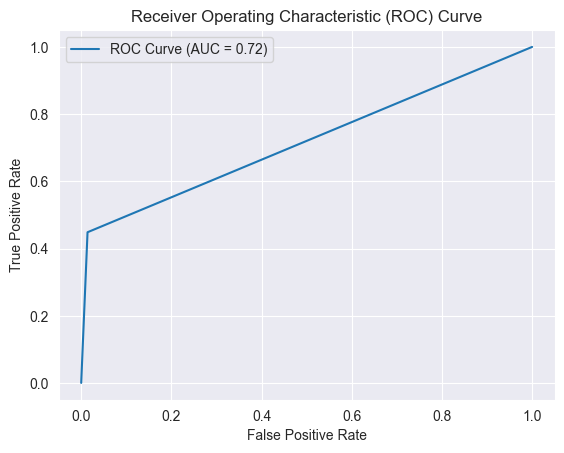

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Chuyển đổi y_true và y_pred thành giá trị nhị phân
LB = LabelBinarizer()
y_true_binary = LB.fit_transform(y_true)
y_pred_binary = LB.transform(y_pred)

# Tính toán roc_curve và auc
fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
auc = roc_auc_score(y_true_binary, y_pred_binary)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()  

# Khó khăn cần tiếp tục giải quyết

- Dù độ chính xác cao (Cả accuracy và validation accuracy đều ổn định ở mức cao), nhưng có một khoảng cách rõ ràng giữa training loss và validation loss. Điều này có thể chỉ ra rằng mô hình có thể đang bắt đầu overfitting.
- Việc nhận dạng văn bản phụ thuộc vào việc phát hiện contour. Vì vậy, nếu thư viện opencv không thể tìm thấy contour của ký tự, thì phương pháp này sẽ thất bại.
- Cần có nhiều hơn các ví dụ khác nhau để huấn luyện mô hình này vì có thể có nhiều biến thể trong một chữ cái viết tay đơn lẻ về phong cách viết.
- Không thể hoạt động với văn bản viết có các ký tự viết nối lại với nhau.